# Creating a Sentiment Predictor

I want to create a sentiment classifier that can look at 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import codecs
import random
from collections import Counter
from IPython.core.display import HTML
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import StandardScaler

from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

%matplotlib inline

I will focus on one group of reviews at first, Amazon's. The data has come to me as a text file so I will need to do a little bit of cleaning to get it into a workable format.

## Importing the Data

In [2]:
import json 

with open('C:\\Code\\Data\\music.json') as f: 
    music = pd.DataFrame(json.loads(line) for line in f)

In [3]:
display(music.describe())

,overall,unixReviewTime
count,10261.000000,1.026100e+04
mean,4.488744,1.360606e+09
std,0.894642,3.779735e+07
min,1.000000,1.095466e+09
25%,4.000000,1.343434e+09
50%,5.000000,1.368490e+09
75%,5.000000,1.388966e+09
max,5.000000,1.405987e+09


In [4]:
print(music.shape)
display(music.head())

(10261, 9)


,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,1384719342,"[0, 0]",5.0,"Not much to write about here, but it does exac...","02 28, 2014",A2IBPI20UZIR0U,"cassandra tu ""Yeah, well, that's just like, u...",good,1393545600
1,1384719342,"[13, 14]",5.0,The product does exactly as it should and is q...,"03 16, 2013",A14VAT5EAX3D9S,Jake,Jake,1363392000
2,1384719342,"[1, 1]",5.0,The primary job of this device is to block the...,"08 28, 2013",A195EZSQDW3E21,"Rick Bennette ""Rick Bennette""",It Does The Job Well,1377648000
3,1384719342,"[0, 0]",5.0,Nice windscreen protects my MXL mic and preven...,"02 14, 2014",A2C00NNG1ZQQG2,"RustyBill ""Sunday Rocker""",GOOD WINDSCREEN FOR THE MONEY,1392336000
4,1384719342,"[0, 0]",5.0,This pop filter is great. It looks and perform...,"02 21, 2014",A94QU4C90B1AX,SEAN MASLANKA,No more pops when I record my vocals.,1392940800


In [5]:
music.reviewText[music.overall>=4]

0        Not much to write about here, but it does exac...
1        The product does exactly as it should and is q...
2        The primary job of this device is to block the...
3        Nice windscreen protects my MXL mic and preven...
4        This pop filter is great. It looks and perform...
5        So good that I bought another one.  Love the h...
6        I have used monster cables for years, and with...
8        Perfect for my Epiphone Sheraton II.  Monster ...
9        Monster makes the best cables and a lifetime w...
10       Monster makes a wide array of cables, includin...
11       I got it to have it if I needed it. I have fou...
13       I love it, I used this for my Yamaha ypt-230 a...
14       I bought this to use in my home studio to cont...
16       This Fender cable is the perfect length for me...
17       wanted it just on looks alone...It is a nice l...
18       I've been using these cables for more than 4 m...
19       Fender cords look great and work just as well..

In [6]:
music.reviewText[music.overall<=2]

15       I bought this to use with my keyboard. I wasn'...
50       I didn't expect this cable to be so thin. It's...
52       It hums, crackles, and I think I'm having prob...
89       I'm a pro-cheapo and I hated this thing. They'...
98       I bought this for my Canon Vixia HF G10 Video ...
144      I got 3 of these to plug XLR cables into the 1...
223      Received it in time, standard blister packagin...
224      These things are terrible. One wouldn't fit in...
286      The handle and spring strength make this uncom...
335      it's good but think its a bit expensive for ju...
376      The Epiphone Les Paul guitars don't particular...
408      This is a cheap piece of junk that does what i...
412      From Greg Abrams review, entitled "For all but...
413      Here's the deal with this pedal. It is inexpen...
482      If you want your guitar to sound like Eddie Va...
542      These came stock on my Jackson Kelly KEXMG. Al...
544      I was very disappointed in both the quality an.

In [7]:
print(music.overall.value_counts())

5.0    6938
4.0    2084
3.0     772
2.0     250
1.0     217
Name: overall, dtype: int64


In [8]:
features = pd.DataFrame()

features['Score'] = music.overall

#Words that identify a positive
keywords_pos = ['good','great','awesome','like','love','well','best','better','sturdy','solid',
                'excellent','must have','exactly','wonderful','nice','budget']

for key in keywords_pos:
    features[str(key)] = music.reviewText.str.contains(str(key),case=False)
    
#Words that identify or negative, or rule out a positive
keywords_neg = ["disappoint","hate","awful",'does not work', "doesn't work","negative",'bummed',
                'problem','junk','not enough','waste','regret','terrible','crap','cheap']

for key in keywords_neg:
    features[str(key)] = music.reviewText.str.contains(str(key),case=False)
    
#Create a feature for whether or not the review was overall positive
features['Positive'] = np.where(features['Score']>=4, 1, 0)

In [9]:
display(features.head())

,Score,good,great,awesome,like,love,well,best,better,sturdy,...,bummed,problem,junk,not enough,waste,regret,terrible,crap,cheap,Positive
0,5.0,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,1
1,5.0,False,False,False,True,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,1
2,5.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3,5.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
4,5.0,False,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1


## Regressor

In [10]:
Xr = features.drop(['Score','Positive'], axis=1)
Yr = features.Score

In [11]:
rfr = ensemble.RandomForestRegressor()

rfr.fit(Xr,Yr)

Y_predr = rfr.predict(Xr)

In [12]:
print('Random Forest Error Score:')
print(rfr.score(Xr,Yr))
cvscore = cross_val_score(rfr, Xr, Yr)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscore.mean(),2),round(cvscore.std()*2,2)))

Random Forest Error Score:
0.2384125973017982

Cross Validation Score:
-0.03% +/- 0.03%


## Classifier

In [13]:
# Take out reviews which were rated 3, as whether or not they were positive could be ambiguous`
features_c = features[features.Score != 3.0]

print(features_c.Positive.value_counts())

1    9022
0     467
Name: Positive, dtype: int64


# Resampling

In [14]:
pos = features_c[features_c.Positive==1]
neg = features_c[features_c.Positive==0]
 
# Downsample positive review class
pos_downsampled = resample(pos, replace=True, n_samples=1000)
#Upsample negative review class
neg_upsampled = resample(neg, replace=True, n_samples=1000)

features_s = pd.concat([pos_downsampled, neg_upsampled])
 
# Display new class counts
display(features_s.Positive.value_counts())

1    1000
0    1000
Name: Positive, dtype: int64

In [15]:
Xs = features_s.drop(['Score','Positive'], axis=1)
Ys = features_s.Positive

### Naive Bayes

In [16]:
bnb = BernoulliNB()

bnb.fit(Xs,Ys)

Y_preds = bnb.predict(Xs)

In [17]:
print('Naive Bayes Error Score:')
print(bnb.score(Xs,Ys))
cvscore = cross_val_score(bnb, Xs, Ys)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscore.mean(),2),round(cvscore.std()*2,2)))
print('\nConfusion Matrix:')
print(confusion_matrix(Ys, Y_preds))

Naive Bayes Error Score:
0.6905

Cross Validation Score:
0.68% +/- 0.01%

Confusion Matrix:
[[780 220]
 [399 601]]


### Random Forest

In [18]:
rfc = ensemble.RandomForestClassifier()

rfc.fit(Xs,Ys)

Y_preds = rfc.predict(Xs)

In [19]:
print('Random Forest Error Score:')
print(rfc.score(Xs,Ys))
cvscore = cross_val_score(rfc, Xs, Ys)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscore.mean(),2),round(cvscore.std()*2,2)))
print('\nConfusion Matrix:')
print(confusion_matrix(Ys, Y_preds))

Random Forest Error Score:
0.777

Cross Validation Score:
0.69% +/- 0.01%

Confusion Matrix:
[[840 160]
 [286 714]]


### Testing Random Forest

In [21]:
X = features.drop(['Score','Positive'], axis=1)
Y = features.Positive

In [22]:
Y_pred = rfc.predict(X)

print('Random Forest Test Error Score:')
print(rfc.score(X,Y))
cvscore = cross_val_score(rfc, X, Y)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscore.mean(),2),round(cvscore.std()*2,2)))
print('\nConfusion Matrix:')
print(confusion_matrix(Y, Y_pred))

Random Forest Test Error Score:
0.665139849917162

Cross Validation Score:
0.87% +/- 0.01%

Confusion Matrix:
[[ 750  489]
 [2947 6075]]


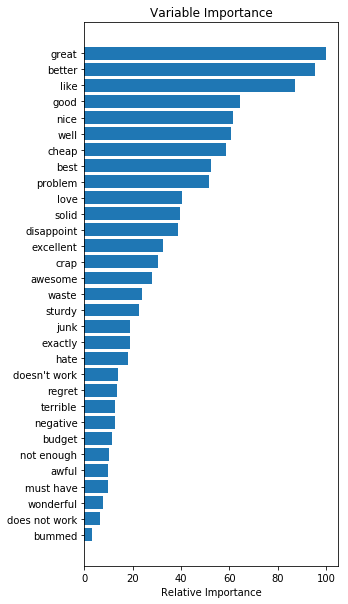

In [24]:
feature_importance = rfc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Different Categories?

In [27]:
with open('C:\\Code\\Data\\car.json') as f: 
    car = pd.DataFrame(json.loads(line) for line in f)

In [28]:
display(car.head())

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B00002243X,"[4, 4]",5.0,I needed a set of jumper cables for my new car...,"08 17, 2011",A3F73SC1LY51OO,Alan Montgomery,Work Well - Should Have Bought Longer Ones,1313539200
1,B00002243X,"[1, 1]",4.0,"These long cables work fine for my truck, but ...","09 4, 2011",A20S66SKYXULG2,alphonse,Okay long cables,1315094400
2,B00002243X,"[0, 0]",5.0,Can't comment much on these since they have no...,"07 25, 2013",A2I8LFSN2IS5EO,Chris,Looks and feels heavy Duty,1374710400
3,B00002243X,"[19, 19]",5.0,I absolutley love Amazon!!! For the price of ...,"12 21, 2010",A3GT2EWQSO45ZG,DeusEx,Excellent choice for Jumper Cables!!!,1292889600
4,B00002243X,"[0, 0]",5.0,I purchased the 12' feet long cable set and th...,"07 4, 2012",A3ESWJPAVRPWB4,E. Hernandez,"Excellent, High Quality Starter Cables",1341360000


In [32]:
with open('C:\\Code\\Data\\lawn.json') as f: 
    lawn = pd.DataFrame(json.loads(line) for line in f)

In [33]:
display(lawn.head())

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B00002N674,"[4, 4]",4.0,Good USA company that stands behind their prod...,"06 21, 2011",A1JZFGZEZVWQPY,"Carter H ""1amazonreviewer@gmail . com""",Great Hoses,1308614400
1,B00002N674,"[0, 0]",5.0,This is a high quality 8 ply hose. I have had ...,"06 9, 2014",A32JCI4AK2JTTG,"Darryl Bennett ""Fuzzy342""",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,1402272000
2,B00002N674,"[2, 3]",4.0,It's probably one of the best hoses I've ever ...,"05 5, 2012",A3N0P5AAMP6XD2,H B,Very satisfied!,1336176000
3,B00002N674,"[0, 0]",5.0,I probably should have bought something a bit ...,"07 15, 2013",A2QK7UNJ857YG,Jason,Very high quality,1373846400
4,B00002N674,"[1, 1]",5.0,I bought three of these 5/8-inch Flexogen hose...,"08 5, 2013",AS0CYBAN6EM06,jimmy,Good Hoses,1375660800


### Testing Car Dataset

In [29]:
car_features = pd.DataFrame()

#Words that identify a positive
keywords_pos = ['good','great','awesome','like','love','well','best','better','sturdy','solid',
                'excellent','must have','exactly','wonderful','nice','budget']

for key in keywords_pos:
    car_features[str(key)] = car.reviewText.str.contains(str(key),case=False)
    
#Words that identify or negative, or rule out a positive
keywords_neg = ["disappoint","hate","awful",'does not work', "doesn't work","negative",'bummed',
                'problem','junk','not enough','waste','regret','terrible','crap','cheap']

for key in keywords_neg:
    car_features[str(key)] = car.reviewText.str.contains(str(key),case=False)
    
#Create a feature for whether or not the review was overall positive
car_features['Positive'] = np.where(car['overall']>=4, 1, 0)

In [30]:
Xcar = car_features.drop(['Positive'], axis=1)
Ycar = car_features.Positive

In [31]:
Y_predcar = rfc.predict(Xcar)

print('Random Forest Test Error Score:')
print(rfc.score(Xcar,Ycar))
cvscore = cross_val_score(rfc, Xcar, Ycar)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscore.mean(),2),round(cvscore.std()*2,2)))
print('\nConfusion Matrix:')
print(confusion_matrix(Ycar, Y_predcar))

Random Forest Test Error Score:
0.5824744785815464

Cross Validation Score:
0.87% +/- 0.0%

Confusion Matrix:
[[ 1559  1019]
 [ 7529 10366]]


### Testing Lawn Dataset

In [34]:
lawn_features = pd.DataFrame()

#Words that identify a positive
keywords_pos = ['good','great','awesome','like','love','well','best','better','sturdy','solid',
                'excellent','must have','exactly','wonderful','nice','budget']

for key in keywords_pos:
    lawn_features[str(key)] = lawn.reviewText.str.contains(str(key),case=False)
    
#Words that identify or negative, or rule out a positive
keywords_neg = ["disappoint","hate","awful",'does not work', "doesn't work","negative",'bummed',
                'problem','junk','not enough','waste','regret','terrible','crap','cheap']

for key in keywords_neg:
    lawn_features[str(key)] = lawn.reviewText.str.contains(str(key),case=False)
    
#Create a feature for whether or not the review was overall positive
lawn_features['Positive'] = np.where(lawn['overall']>=4, 1, 0)

In [35]:
Xlawn = lawn_features.drop(['Positive'], axis=1)
Ylawn = lawn_features.Positive

In [36]:
Y_predlawn = rfc.predict(Xlawn)

print('Random Forest Test Error Score:')
print(rfc.score(Xlawn,Ylawn))
cvscore = cross_val_score(rfc, Xlawn, Ylawn)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscore.mean(),2),round(cvscore.std()*2,2)))
print('\nConfusion Matrix:')
print(confusion_matrix(Ylawn, Y_predlawn))

Random Forest Test Error Score:
0.6149035563592525

Cross Validation Score:
0.78% +/- 0.0%

Confusion Matrix:
[[1465 1386]
 [3725 6696]]


http://jmcauley.ucsd.edu/data/amazon/